In [1]:
from MCMC_Class import DPPM_MCMC
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

INFO: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.


In [2]:
import numpy as np

def generate_sparse_degenerate_normal(mean_vector, dim, num_samples, rank_deficiency, sparsity_factor):
    """
    Generates samples from a sparse, high-dimensional, degenerate normal distribution.

    Args:
        mean_vector (np.ndarray): 1D array representing the mean of the distribution.
                                  Its length defines the dimensionality.
        dim (int): The dimensionality of the distribution.
        num_samples (int): The number of samples to generate.
        rank_deficiency (int): How much the rank of the covariance matrix is reduced
                               from the full dimension (e.g., 1 for rank dim-1).
        sparsity_factor (float): A value between 0 and 1. Higher values mean more
                                 zero entries in the covariance matrix.

    Returns:
        np.ndarray: An array of shape (num_samples, dim) containing the generated samples.
    """

    if not (0 <= sparsity_factor <= 1):
        raise ValueError("sparsity_factor must be between 0 and 1.")
    if not (0 <= rank_deficiency < dim):
        raise ValueError("rank_deficiency must be between 0 and dim-1.")
    if len(mean_vector) != dim:
        raise ValueError("Length of mean_vector must match dim.")

    # 1. Create a low-rank (degenerate) covariance matrix
    # We can do this by constructing a matrix from a lower-dimensional basis
    effective_dim = dim - rank_deficiency
    if effective_dim <= 0:
        raise ValueError("Effective dimension for generating non-zero covariance is too low.")

    # Create a random positive semi-definite matrix of lower rank
    # This ensures the matrix is valid as a covariance matrix
    low_rank_matrix = np.random.rand(dim, effective_dim)
    covariance_matrix_base = low_rank_matrix @ low_rank_matrix.T

    # 2. Introduce sparsity into the covariance matrix
    # Randomly set a fraction of elements to zero
    num_elements = covariance_matrix_base.size
    num_zeros = int(sparsity_factor * num_elements)
    zero_indices = np.random.choice(num_elements, num_zeros, replace=False)
    
    sparse_covariance_matrix = covariance_matrix_base.flatten()
    sparse_covariance_matrix[zero_indices] = 0
    sparse_covariance_matrix = sparse_covariance_matrix.reshape(dim, dim)

    # Ensure symmetry (important for covariance matrices)
    sparse_covariance_matrix = (sparse_covariance_matrix + sparse_covariance_matrix.T) / 2

    # Ensure positive semi-definiteness (add a small diagonal term if needed to prevent numerical issues)
    # This is crucial for np.random.multivariate_normal to work correctly.
    # A small epsilon can be added to the diagonal if the matrix becomes non-positive semi-definite
    # due to sparsity, potentially making it non-degenerate again in a very small way.
    # However, for true degeneracy, ensure the rank is genuinely reduced.
    # For this example, we assume the low_rank_matrix construction and subsequent
    # sparsification maintain approximate positive semi-definiteness.

    # 3. Generate samples
    samples = np.random.multivariate_normal(mean_vector, sparse_covariance_matrix, size=num_samples)
    return samples

# Example usage:
high_dim = 100
num_samples_gen = 1000
mean = np.zeros(high_dim)  # Mean vector
rank_def = 50              # Reduce rank by 50 (e.g., rank will be 50)
sparsity = 0.8             # 80% of covariance matrix elements will be zero

degenerate_sparse_samples = generate_sparse_degenerate_normal(
    mean_vector=mean,
    dim=high_dim,
    num_samples=num_samples_gen,
    rank_deficiency=rank_def,
    sparsity_factor=sparsity
)

print(f"Shape of generated samples: {degenerate_sparse_samples.shape}")

Shape of generated samples: (1000, 100)


/var/folders/md/8sg8cmjs2qzgxyk9171wzgcr0000gn/T/ipykernel_43564/655258059.py:61: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean_vector, sparse_covariance_matrix, size=num_samples)


In [3]:
mcmc = DPPM_MCMC(
   degenerate_sparse_samples,
    K=50,
    sampler_type="collapsed",      # or "uncollapsed"
    G_update="vmf_geomstats",      # <<< use geomstats-based vMF update
    random_state=42
)

samples = mcmc.run(n_iter=2000, burn_in=1000, thin=3)

In [ ]:
samples

{'G': array([[[-0.07822445,  0.04474457,  0.07706027, ..., -0.0239995 ,
           0.08418955,  0.00816666],
         [-0.08876257, -0.004391  ,  0.09265561, ..., -0.00310299,
           0.14758828, -0.00455819],
         [-0.12885186, -0.08542342, -0.07473249, ...,  0.03056778,
          -0.1443708 , -0.09558944],
         ...,
         [-0.04827772, -0.02551719,  0.04463954, ..., -0.11425298,
          -0.04569545, -0.17866698],
         [-0.07831723,  0.07399982, -0.0081138 , ...,  0.11760718,
          -0.13999437,  0.08843718],
         [-0.07855944, -0.0163898 , -0.06583892, ...,  0.18877109,
          -0.1369549 , -0.05214064]],
 
        [[-0.08328208,  0.02077305,  0.0535164 , ..., -0.12236248,
          -0.14529911,  0.09278254],
         [-0.09903819, -0.00686704,  0.11914756, ..., -0.13018256,
          -0.16835801, -0.021397  ],
         [-0.11170805, -0.09204556, -0.0989069 , ...,  0.01090613,
           0.07398722, -0.08498524],
         ...,
         [-0.05790219,  0.02

<Axes: >

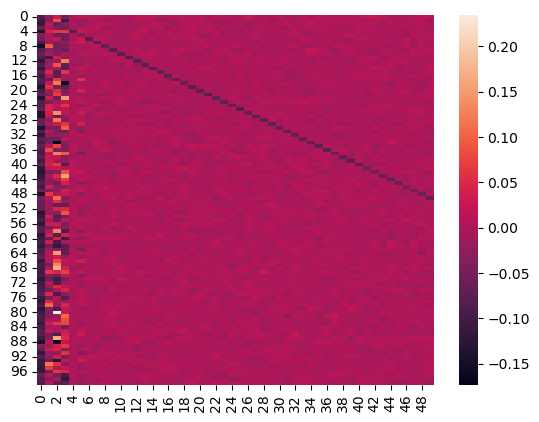

In [14]:
sb.heatmap(np.mean(samples['G'],axis=0))
